# **<span style="color: red;">REGRESSION TASK</span>**

# **1. Violent Crime Rate California 2000-2013**
---
***(https://catalog.data.gov/dataset/violent-crime-rate-94cb9)***

## **1.1 Importing Libraries**
---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## **1.2 Printing CSV file**
---
Printing the .csv file to check for errors.
To begin cleaning data to fix errors, the column names should be known. 

In [2]:
cali_cr = pd.read_csv("/kaggle/input/california-crimerate/violent-crime-rate-california-2000-2013.csv")
print(cali_cr)
cali_cr.columns

             ind_id                                 ind_definition  \
0               752  Number of Violent Crimes per 1,000 Population   
1               752  Number of Violent Crimes per 1,000 Population   
2               752  Number of Violent Crimes per 1,000 Population   
3               752  Number of Violent Crimes per 1,000 Population   
4               752  Number of Violent Crimes per 1,000 Population   
...             ...                                            ...   
49222           752  Number of Violent Crimes per 1,000 Population   
49223           752  Number of Violent Crimes per 1,000 Population   
49224           752  Number of Violent Crimes per 1,000 Population   
49225           752  Number of Violent Crimes per 1,000 Population   
49226  END OF TABLE                                            NaN   

       reportyear  race_eth_code race_eth_name geotype  geotypevalue  \
0          2000.0            9.0         Total      CA           6.0   
1          2000

/tmp/ipykernel_13/4142178713.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  cali_cr = pd.read_csv("/kaggle/input/california-crimerate/violent-crime-rate-california-2000-2013.csv")
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


Index(['ind_id', 'ind_definition', 'reportyear', 'race_eth_code',
       'race_eth_name', 'geotype', 'geotypevalue', 'geoname', 'county_fips',
       'county_name', 'region_code', 'region_name', 'strata_name_code',
       'strata_name', 'strata_level_name_code', 'strata_level_name',
       'numerator', 'denominator', 'rate', 'll_95ci', 'ul_95ci', 'se', 'rse',
       'ca_decile', 'ca_rr', 'dof_population', 'version'],
      dtype='object')

## **1.3 Cleaning**
---
There are NaN values in two relevant columns, 'county_name', and 'rate'. In the dataset, the problem with county_name is that it is empty because it's used for the whole state of California instead of different counties. In regards to the rate, the errors are because the rates are only present on rows that are for the total number of violent crimes committed instead of something specific like assault, etc.

In [3]:
cali_cr_clean = cali_cr.dropna(subset=['county_name', 'rate'])
cali_cr_clean = cali_cr_clean[['reportyear', 'county_name', 'numerator', 'denominator', 'rate']]

print(cali_cr_clean)

       reportyear     county_name  numerator  denominator      rate
9          2000.0         Alameda     9503.0    1443741.0  6.582206
14         2000.0          Alpine       10.0       1208.0  8.278146
19         2000.0          Amador      179.0      34120.0  5.246190
24         2000.0           Butte      699.0     203171.0  3.440452
29         2000.0       Calaveras      118.0      40554.0  2.909701
...           ...             ...        ...          ...       ...
49131      2013.0          Orange       30.0      67492.0  0.444497
49139      2013.0        Siskiyou       49.0       7639.0  6.414452
49144      2013.0          Sutter      174.0      65133.0  2.671457
49149      2013.0  San Bernardino      107.0      52524.0  2.037164
49154      2013.0  San Bernardino       86.0      21214.0  4.053927

[7113 rows x 5 columns]


In the described data, it seems like the highest rate is at **795** in <u>Vernon City</u>. It raised some flags, so checking the reason was necessary. After a quick search, it was indeed true that the population of residents was low (**93**), but apparently the city itself is just **full of workers** since it's an "**exclusively industrial area**". Similarly, the second highest rate that was another city is called <u>Industry City</u>. We can then assume that they face similar issues of extremely high / skewed population to crime-rate ratios.

### **1.41 Decision Tree Model**
---

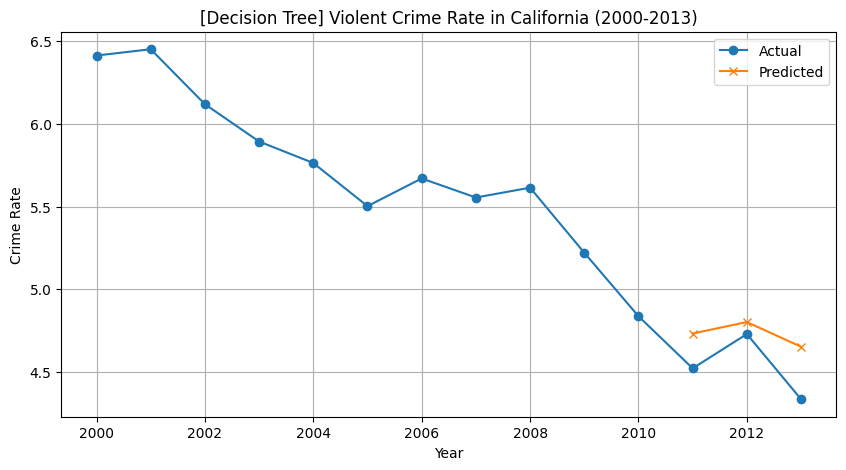

In [4]:
# --- County names are strings which cannot be read by the model ---
combined = pd.get_dummies(cali_cr_clean, columns=['county_name'], drop_first=True)

# --- Predicting future trends based on 2000-2010 data ---
train = combined[combined['reportyear'] <= 2010]
test  = combined[combined['reportyear'] > 2010]

# --- 2000-2010 data ---
train_X = train.drop(columns=['rate'])
train_y = train['rate']

# --- 2011-2013 data ---
val_X = test.drop(columns=['rate'])
val_y = test['rate']

# --- Decision Tree Regression Model ---
crimerate_model = DecisionTreeRegressor(random_state=1)
crimerate_model.fit(train_X, train_y)

# --- Making predictions ---
val_predictions = crimerate_model.predict(val_X)

# --- Copying data to test and adding predicted crime rates ---
test = combined[combined['reportyear'] > 2010].copy()
test['predicted_rate'] = val_predictions

# --- Average of rates in a year ---
actual_data = cali_cr_clean.groupby('reportyear')['rate'].mean()
predicted_data = test.groupby('reportyear')['predicted_rate'].mean()

# --- Visualization ---
plt.figure(figsize=(10,5))
plt.plot(actual_data.index, actual_data.values, marker='o', label='Actual')
plt.plot(predicted_data.index, predicted_data.values, marker='x', label='Predicted')
plt.xlabel("Year")
plt.ylabel("Crime Rate")
plt.title("[Decision Tree] Violent Crime Rate in California (2000-2013)")
plt.legend()
plt.grid(True)
plt.show()

In [5]:
print(f"Predicted crime rates 2011-2013:\n{val_predictions[0:5]}\n")
print(f"Actual crime rates 2011-2013:\n{val_y.values[0:5]}\n")
print(f"Training data:\n{train_y.head()}")

val_mae = mean_absolute_error(val_y, val_predictions)
val_mse = mean_squared_error(val_y, val_predictions)
r2 = r2_score(val_y, val_predictions)

print(f"\nMean Absolute Error: {val_mae}")
print(f"Mean Squared Error: {val_mse}")
print(f"R² score: {r2}")

Predicted crime rates 2011-2013:
[5.94009844 5.84307179 2.5743783  3.03942555 2.78356115]

Actual crime rates 2011-2013:
[7.05812597 5.88730025 2.54287864 2.58776383 2.60224661]

Training data:
9     6.582206
14    8.278146
19    5.246190
24    3.440452
29    2.909701
Name: rate, dtype: float64

Mean Absolute Error: 0.4813252669849279
Mean Squared Error: 29.779325890044607
R² score: 0.8730774920611438


#### **1.41a Random Forest Model**
---

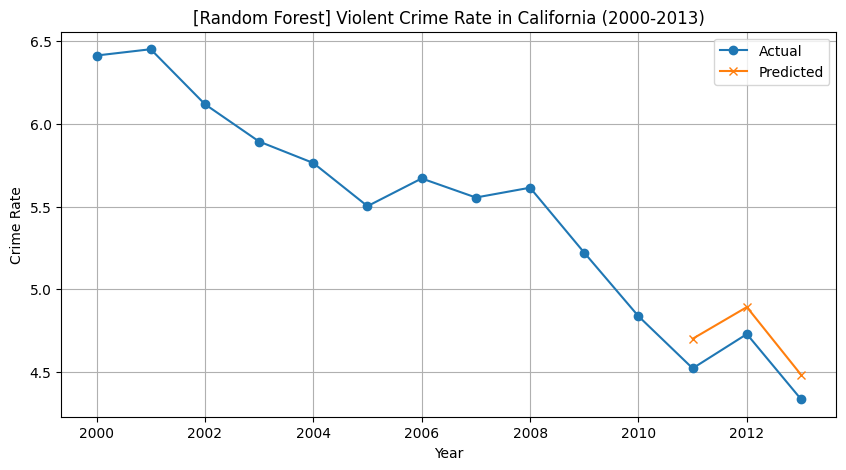

In [6]:
# --- Preparing the model ---
rf_test = test.copy()
rf_model = RandomForestRegressor(random_state = 1)
rf_model.fit(train_X, train_y)

cali_preds = rf_model.predict(val_X)
rf_test['predicted_rate'] = cali_preds

predicted_data = rf_test.groupby('reportyear')['predicted_rate'].mean()

# --- Visualization ---
plt.figure(figsize=(10,5))
plt.plot(actual_data.index, actual_data.values, marker='o', label='Actual')
plt.plot(predicted_data.index, predicted_data.values, marker='x', label='Predicted')
plt.xlabel("Year")
plt.ylabel("Crime Rate")
plt.title("[Random Forest] Violent Crime Rate in California (2000-2013)")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
print(f"Predicted crime rates 2011-2013:\n{val_predictions[0:5]}\n")
print(f"Actual crime rates 2011-2013:\n{val_y.values[0:5]}\n")
print(f"Training data:\n{train_y.head()}")

rf_val_mae = mean_absolute_error(val_y, cali_preds)
rf_val_mse = mean_squared_error(val_y, cali_preds)
r2 = r2_score(val_y, cali_preds)

print(f"\nMean Absolute Error: {rf_val_mae}")
print(f"Mean Squared Error: {rf_val_mse}")
print(f"R² score: {r2}")

Predicted crime rates 2011-2013:
[5.94009844 5.84307179 2.5743783  3.03942555 2.78356115]

Actual crime rates 2011-2013:
[7.05812597 5.88730025 2.54287864 2.58776383 2.60224661]

Training data:
9     6.582206
14    8.278146
19    5.246190
24    3.440452
29    2.909701
Name: rate, dtype: float64

Mean Absolute Error: 0.32246425048507177
Mean Squared Error: 15.066200298436039
R² score: 0.9357863259213024


### **1.42 Optimizing Prediction**
---
Predicted values are hovering near actual values. The models will be optimized further to bring the MAE down. Unfortunately, I was not able to find a method for optimizing the random forest model within my limited time working on this task.

#### **1.42a Optimized Decision Tree Model**

In [8]:
# --- Code from Kaggle Learn (Intro to Machine Learning) ---
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

candidate_max_leaf_nodes = [5, 25, 50, 100, 250, 500]

mae_list = []
for max_leaf_nodes in candidate_max_leaf_nodes:
    my_mae = get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y)
    mae_list.append(my_mae)

best_tree_size = candidate_max_leaf_nodes[mae_list.index(min(mae_list))]

final_model = DecisionTreeRegressor(max_leaf_nodes=best_tree_size, random_state=0)

final_model.fit(train_X, train_y)

val_predictions = final_model.predict(val_X)

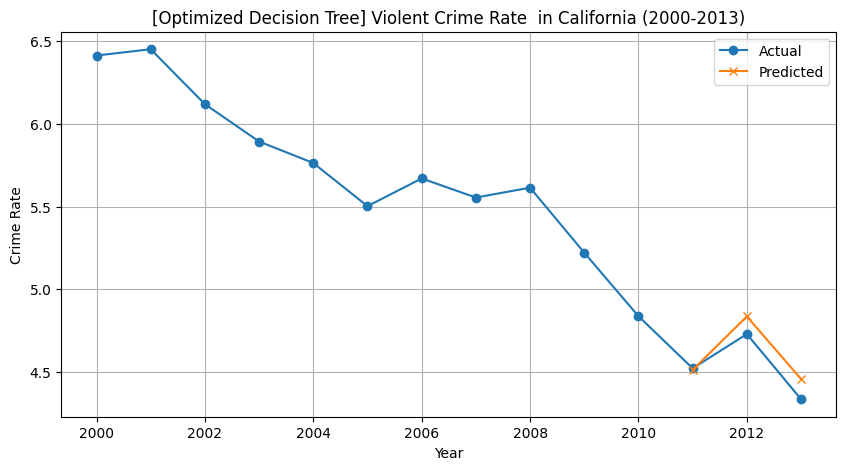

In [9]:
test['predicted_rate'] = val_predictions
predicted_data = test.groupby('reportyear')['predicted_rate'].mean()

# --- Visualization ---
plt.figure(figsize=(10,5))
plt.plot(actual_data.index, actual_data.values, marker='o', label='Actual')
plt.plot(predicted_data.index, predicted_data.values, marker='x', label='Predicted')
plt.xlabel("Year")
plt.ylabel("Crime Rate")
plt.title("[Optimized Decision Tree] Violent Crime Rate  in California (2000-2013)")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
print(f"Predicted crime rates 2011-2013:\n{val_predictions[0:5]}\n")
print(f"Actual crime rates 2011-2013:\n{val_y.values[0:5]}\n")
print(f"Training data:\n{train_y.head()}")

final_mae = mean_absolute_error(val_y, val_predictions)
final_mse = mean_squared_error(val_y, val_predictions)
r2 = r2_score(val_y, val_predictions)

print(f"\nOptimized Mean Absolute Error: {final_mae}")
print(f"Optimized Mean Squared Error: {final_mse}")
print(f"Optimized R² score: {r2}")

Predicted crime rates 2011-2013:
[6.50228332 6.51187841 2.45530241 2.68217703 2.90095971]

Actual crime rates 2011-2013:
[7.05812597 5.88730025 2.54287864 2.58776383 2.60224661]

Training data:
9     6.582206
14    8.278146
19    5.246190
24    3.440452
29    2.909701
Name: rate, dtype: float64

Optimized Mean Absolute Error: 0.42723345029301285
Optimized Mean Squared Error: 5.28292815990416
Optimized R² score: 0.977483624250205


This time, the predicted data is now closer to the actual data. 2011 and 2013 figures are closer now, at the cost of 2012 being higher than expected.

### **1.43 Linear Regression**
---
Linear Regression isn't as useful than the other models since the dataset contains fluctuating data. However, it will still be used for visualizing the overall downwards trend for crime rates in California. 

[6.47559437 6.32137846 6.16716255 6.01294663 5.85873072 5.70451481
 5.5502989  5.39608298 5.24186707 5.08765116 4.93343525 4.77921934
 4.62500342 4.47078751]
Coefficient: [-0.15421591]
Intercept: 314.90741877886967


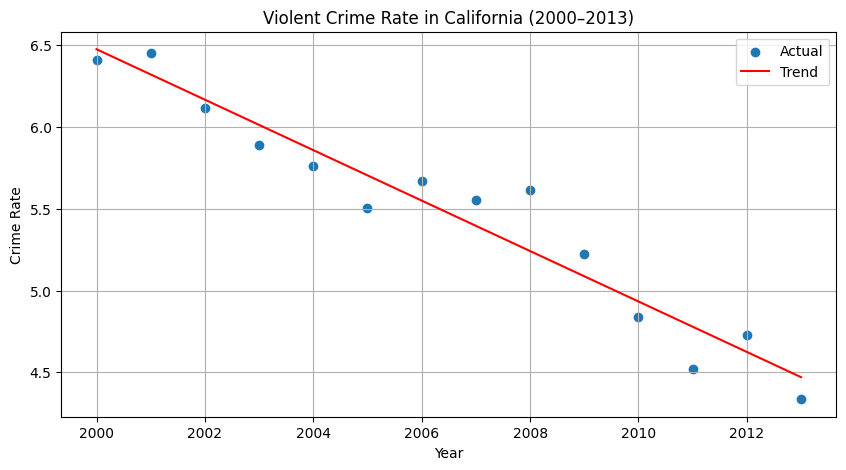

In [11]:
yearly_trend = cali_cr_clean.groupby('reportyear')['rate'].mean()

X = yearly_trend.index.values.reshape(-1, 1)
y = yearly_trend.values                       

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)
print(y_pred)
print(f"Coefficient: {model.coef_}")
print(f"Intercept: {model.intercept_}")

plt.figure(figsize=(10,5))
plt.scatter(X, y, label='Actual')
plt.plot(X, y_pred, color='red', label='Trend')
plt.title('Violent Crime Rate in California (2000–2013)')
plt.xlabel('Year')
plt.ylabel('Crime Rate')
plt.grid()
plt.legend()
plt.show()

# **2. Deliverables**

## **2.1 Dataset Description**
This dataset is regarding the state of California's Violent Crime Rate over the course of the years 2000-2013.

The .CSV file contains 49227 rows and 27 columns. Of those columns, only five are most relevant for the task at hand. Those five columns are: 'reportyear', 'county_name', 'numerator', 'denominator', 'rate'. Since report year and county name are self-explanatory, only the three remaining columns will be defined.

The numerator is the number of crimes by type of crime. After preprocessing the dataset, the numerator is just the total number of violent crimes in a given place.

The denominator is the total population of the place reported by the Federal Bureau of Investigation.

The rate is already scaled to be the number of violent crimes per 1000 population.


## **2.2 Preprocessing**
### 2.2a Cleaning:
The county_name and rate records have the most NaN values and are the most relevant in the dataset. These columns will have their NaN rows dropped. They are safe to drop because the errors in county_name are because the empty rows represent the state of California, and the errors in rates are because the empty rows represent other types of violent crime, which isn't needed for the task.

### 2.2b Turning county_name string into dummy data:
pd.getdummies() is used on county_name since strings can't be easily read by the models. It turns the categorical data (ex: "Alameda") into numerical data (True/False : 1/0, binary).

### 2.2c Setting variables:
In this task, I wanted to see if it was possible to predict future yearly rates using old data. For this scenario, I used the years 2000-2010 data to train the model and to see if the predicted 2011-2013 rates were close to the actual values in the dataset.

### 2.2d Splitting data:
Two variables were used to represent as data from the years 2010 and below, and the years 2011 to 2013 respectively. Those were then used to fit the corresponding models.


## **2.3 Model Implementation**
### 2.3a Decision Tree:
I implemented the Decision Tree model to predict crime rates based on the reported years and their rates. The model was trained on 2000-2010 data, with 2011-2013 data as validation. This model was chosen for its ease of visualization and interpretation.

### 2.3b Random Forest:
The Random Forest model was used to improve prediction accuracy since it can generalize better than decision trees. It was also chosen because the Decision Tree and Random Forest models were used in the Intro to Machine Learning course on Kaggle Learn.

### 2.3c Optimizing Results:
I was able to optimize the decision tree model by reusing the code from the Kaggle Learn course. I was unable to find a way to optimize the Random Forest model because I couldn't find a point of reference to rely on within my limited time working on the task.

### 2.3d Linear Regression:
This model was used only as part of the Machine Learning task requirement. It has some use, such as showing the trend of the violent crime rate over the years, although the other models are more suited for the prediction task.


## **2.4 Results**
### 2.4a Decision Tree:
The predicted data for the years 2011-2013 are off by a few decimals. However, the curve isn't as pronounced as the actual data.

### 2.4b Random Forest:
The predicted data for the years 2011-2013 are off by a few decimals. The curve is similar to the actual data.

### 2.4c Optimized Decision Tree:
The predicted data for the years 2011-2013 are somewhat close. The year 2011 had the closest similarity but was slightly off in the negatives.The year 2012 saw an increase over the unoptimized Decision Tree. The year 2012-2013's trend is correct, but the actual and predicted values are parallel because the predicted values are slightly off in the positives.

### 2.4d Linear Regression:
The Linear Regression model result shows that there is a general downwards trend for violent crimes in the state of California.

## **2.5 Interpretation**
### 2.5a Decision Tree:
Mean Absolute Error: 0.4813252669849279

Mean Squared Error: 29.779325890044607

R² score: 0.8730774920611438

The MAE shows that the predicted values are 0.48 units away from the actual data. The R² score meanwhile says that the model explains 87.3% of the variation in crime rates.

### 2.5b Random Forest:
Mean Absolute Error: 0.32246425048507177

Mean Squared Error: 15.066200298436039

R² score: 0.9357863259213024

The MAE shows that the predicted values are 0.32 units away from the actual data. The R² score meanwhile says that the model explains 93.5% of the variation in crime rates.

### 2.5c Optimized Decision Tree
Optimized Mean Absolute Error: 0.42723345029301285

Optimized Mean Squared Error: 5.28292815990416

Optimized R² score: 0.977483624250205

The MAE shows that the predicted values are 0.42 units away from the actual data. The R² score meanwhile says that the model explains 97.7% of the variation in crime rates.

### 2.5d Linear Regression
The coefficient (-0.15421591) means that the predicted crime rate decreases by 0.154 units every year.

## **2.6 Critical Reflection**
Taking the Intro to Machine Learning course on Kaggle was the best course of action I could have taken. Initially, I progressed with this experiment through only using information I learned in class—cross-referencing previous notebook tests and the like. However, it proved to be rather inefficient in regard to how I used my time while working on the task. There were days when I had spent four hours mostly absentmindedly just trying to copy what I did for the Machine Learning classes—like the salary regression task, etc. After finishing the optional course, I went back to working on my Experiment 1 with a renewed vision on what to do.

I restarted my progress with the Regression Task because my previous attempts were unclear about what I wanted to do. Initially, I wanted to visualize the yearly trend of all 58 counties in the state of California. However, I then realized that it would have made the task unnecessarily long. Because of that, I only went ahead to get the overall numbers for the state of California by using the counties instead. Due to my completion of the Kaggle Learn course, I was able to use the information there, as well as my exercise attempts, as a reference for the regression task.

I can say that this experiment has piqued my interest in learning more about Machine Learning. In this experiment, I used the dataset’s year 2000-2010 reported crime rates to train the models and see if it was possible to predict future years’ crime rates. I only used the years 2011-2013 for prediction since I could compare the predicted crime rates with the actual crime rates in those years. I was able to use the Decision Tree and Random Forest models to aid with the prediction task; I also optimized the Decision Tree model to get more accurate results. It was surprising to see that they were almost able to predict the way the rates were going to move, even more so that the optimized Decision Tree model was able to predict the 2011 mean at a very low error. Unfortunately, I couldn’t find a way to optimize the Random Forest model since my limited time for this task meant that I couldn’t spend more time reading more about this topic. If the Random Forest model had been optimized, then it could have most likely gotten excellent predictions since the unoptimized version of the Random Forest model was already better than the unoptimized Decision Tree model.